In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import matplotlib
matplotlib.rcdefaults()
import sys
#sys.path.insert(1, '/home/suarez08/PhD_PINNs/PIPS_framework')
from sobolev import Sobolev

In [2]:
# Properties class to store the properties of each particle
class Props:
    def __init__(self, field_val, derivs):
        self.field = field_val
        self.field_derivative = derivs

In [3]:
class Particle:
    def __init__(self, position, properties):
        self.position = position
        self.properties = properties

    def interact(self, other_particle):
        pass

    def evolve(self):
        pass


In [4]:
class ParticleSet:

    def __init__(self, positions, properties):
        # positions: array of shape (N, d)
        # properties: array of shape (N)
        self.num_particles = positions.shape[0]
        self.spatial_dimesion = positions.shape[1]
        self.particles = []
        for i in range(self.num_particles):
            self.particles.append(Particle(positions[i,:], properties[i]))

    def update_once(self):
        pass

    def compute_derivatives(self, verlet_list, deriv_func, eps, V):
        for p_idx, p in enumerate(self.particles):
            result = 0.0
            neighbours = verlet_list.neighbours[p_idx]
            for q_idx in neighbours:
                q = self.particles[q_idx]
                if q != p:
                    z = p.position[0] - q.position[0]
                    result += q.properties.field * deriv_func(z, eps) * V
            p.properties.field_derivative = result
        return

In [5]:
class CellList:

    def __init__(self, particle_set, rc):
        self.cells = {}
        self.construct(particle_set, rc)

    def construct(self, particle_set, rc):
        for idx, p in enumerate(particle_set.particles):
            cell_index_x = np.floor((p.position) / rc).astype(int)
            cell_index = cell_index_x[0]
            if cell_index in self.cells.keys():
                self.cells[cell_index].append(idx)
            else:
                self.cells[cell_index] = [idx]

    def particles_in(self, cell_index):
        if cell_index in self.cells.keys():
            return self.cells[cell_index]
        else:
            return []

    def neighbourhood(self, cell_index):
        cell_index_x = cell_index[0]
        neighbour_list = []
        for lx in [-1, 0,1]:
            neighbour_list.extend(self.particles_in(cell_index_x + lx))

        return neighbour_list

In [6]:
class VerletList:

    def __init__(self, particle_set, cell_list, rc):
        self.neighbours = {}
        self.construct(particle_set, cell_list, rc)

    def construct(self, particle_set, cell_list, rc):
        for p_id, p in enumerate(particle_set.particles):
            self.neighbours[p_id] = []
            cell_index_x = np.floor((p.position) / rc).astype(int)
            cell_index = cell_index_x
            for q_id in cell_list.neighbourhood(cell_index):
                q = particle_set.particles[q_id]
                if np.linalg.norm(p.position[0]-q.position[0]) <= rc:
                    self.neighbours[p_id].append(q_id)

In [7]:
def f(x):
    return np.sin(10*x)*x**2
def dxf(x):
    return  2*x*(5*x*np.cos(10*x) + np.sin(10*x))
def kernel(z, eps):
    alphad = 2.0/eps
    z = np.abs(z)
    if z < 0.5*eps:
        return alphad*(2.0/3.0 - (2.0*z/eps)**2 + 0.5*(2.0*z/eps)**3)
    elif z >= 0.5*eps and z < eps:
        return alphad*(((1.0/6.0)*(2.0-2.0*z/eps)**3))
    else:
        return 0.0

def deriv_kernel(z, eps):
    if z!=0:
        sign = z/np.abs(z)
    else:
        sign = 1
    z = np.abs(z)
    alphad = sign*2.0/eps
    if z < 0.5*eps:
        return alphad*((-8.0*z/(eps**2)) + (12.0*z**2/eps**3))
    elif z >= 0.5*eps and z < eps:
        return alphad*(-1*(2.0-2.0*z/eps)**2/eps)
    else:
        return 0.0


In [8]:
N = 100
d = 1

positions = np.linspace(-1,1,N)
h=positions[1]-positions[0]
print(f"h = {h}")

positions = positions.reshape(N,1)
rc = 5.0*h
print(f"Cut off for Cell list = {rc}")

# Initialize particle positions with function values
properties = []
for idx in range(N):
    p = Props(f(positions[idx]), 0.0)
    properties.append(p)

# Initial particle set
pset = ParticleSet(positions, properties)
cell_list = CellList(pset, rc)
verlet_list = VerletList(pset, cell_list, rc)
# Compute the first derivative using SPH kernel
pset.compute_derivatives(verlet_list, deriv_kernel, eps=2*h, V=h)

h = 0.02020202020202022
Cut off for Cell list = 0.1010101010101011


In [9]:
Pred = [pset.particles[k].properties.field_derivative[0] for k in range(len(positions))]

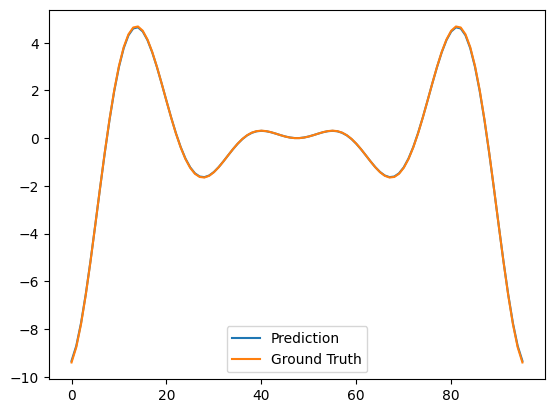

In [10]:
filt_part = np.array(pset.particles)[idx]
plt.plot(Pred[2:-2],label='Prediction')
plt.plot(dxf(positions)[2:-2], label = 'Ground Truth')
plt.legend()

In [11]:
deg_quad = 40
sob_param = Sobolev(deg=deg_quad, dim=1)
x_plt, _, _, x_int, _, _ = sob_param.get_quad()
w_1d = np.array(sob_param.get_leja_weights())
dx =sob_param.diff.diffs(np.array([[1]]))

In [23]:
deg_quad = 40
sob_param = Sobolev(deg=deg_quad, dim=1)
x_plt, _, _, x_int, _, _ = sob_param.get_quad()
w_1d = np.array(sob_param.get_leja_weights())
dx =sob_param.diff.diffs(np.array([[1]]))
def sph_int(N):
    d = 1
    positions = np.linspace(-1,1,N)
    h=positions[1]-positions[0]
    positions = positions.reshape(N,1)
    rc = 5.0*h
    properties = []
    for idx in range(N):
        p = Props(f(positions[idx]), 0.0)
        properties.append(p)

    # Initial particle set
    pset = ParticleSet(positions, properties)
    cell_list = CellList(pset, rc)
    verlet_list = VerletList(pset, cell_list, rc)
    # Compute the first derivative using SPH kernel
    coor_p = np.array([pset.particles[k].position[0] for k in range(len(pset.particles))])
    ID = np.array([[idx, x_p] for idx, x_p in enumerate(coor_p) if x_p <=1 and x_p >=-1])
    idx = np.array(ID[:,0],dtype = int)
    V = h
    eps = 2*h
    x = x_int
    F = []
    Fx = []
    for i in range(len(x)):
        x_i = x_int[i]#positions.T[0][i]+0.1#x[i]
        result = 0.0
        resultdx = 0.0
        IDX = np.floor((x_i) / rc).astype(int)
        neighbours = cell_list.neighbourhood([IDX])
        for j, i_idx in enumerate(neighbours):
            for j, j_idx in enumerate(neighbours):
                qi = pset.particles[i_idx]
                qj = pset.particles[j_idx]
                zi = x_i - qi.position[0]
                zj = x_i - qj.position[0]
                result +=qi.properties.field * qj.properties.field * kernel(zi, eps)* kernel(zj, eps) * V**2
                resultdx +=qi.properties.field * qj.properties.field * deriv_kernel(zi, eps)* deriv_kernel(zj, eps) * V**2
        F.append(result)
        Fx.append(resultdx)
    return np.sum(np.array(F).T[0]*w_1d)+np.sum(np.array(Fx).T[0]*w_1d)#, np.sum(f(positions[idx])**2*V)

In [24]:
an_int = np.sum((dx@f(x_int))**2*w_1d) +  np.sum((f(x_int))**2*w_1d)

In [25]:
x_mse = np.linspace(-1,1,10000)
x_mse = x_mse[np.random.randint(0,10000,100)]
dx = abs(x_mse[0]-x_mse[1])
def mse_sph_int(N):
    d = 1
    positions = np.linspace(-1,1,N)
    h=positions[1]-positions[0]
    positions = positions.reshape(N,1)
    rc = 5.0*h
    properties = []
    for idx in range(N):
        p = Props(f(positions[idx]), 0.0)
        properties.append(p)

    # Initial particle set
    pset = ParticleSet(positions, properties)
    cell_list = CellList(pset, rc)
    verlet_list = VerletList(pset, cell_list, rc)
    # Compute the first derivative using SPH kernel
    coor_p = np.array([pset.particles[k].position[0] for k in range(len(pset.particles))])
    ID = np.array([[idx, x_p] for idx, x_p in enumerate(coor_p) if x_p <=1 and x_p >=-1])
    idx = np.array(ID[:,0],dtype = int)
    V = h
    eps = 2*h
    x_int = x
    F = []
    Fx = []
    for i in range(len(x_mse)):
        x_i = x_mse[i]#positions.T[0][i]+0.1#x[i]
        result = 0.0
        resultdx = 0.0
        IDX = np.floor((x_i) / rc).astype(int)
        neighbours = cell_list.neighbourhood([IDX])
        for j, i_idx in enumerate(neighbours):
            for j, j_idx in enumerate(neighbours):
                qi = pset.particles[i_idx]
                qj = pset.particles[j_idx]
                zi = x_i - qi.position[0]
                zj = x_i - qj.position[0]
                result +=qi.properties.field * qj.properties.field * kernel(zi, eps)* kernel(zj, eps) * V**2
                resultdx +=qi.properties.field * qj.properties.field * deriv_kernel(zi, eps)* deriv_kernel(zj, eps) * V**2
        F.append(result)
        Fx.append(resultdx)
    return np.mean(np.array(F).T[0]) +  np.mean(np.array(Fx).T[0])

In [26]:
def MSE_int(N):
    d = 1
    positions = np.linspace(-1,1,N)
    coor_p = np.array([positions[k] for k in range(len(positions))])
    ID = np.array([[idx, x_p] for idx, x_p in enumerate(coor_p) if x_p <=1 and x_p >=-1])
    idx = np.array(ID[:,0],dtype = int)
    h=positions[1]-positions[0]
    return  np.sum(dxf(positions[idx])**2*h) + np.sum(f(positions[idx])**2*h)

In [27]:
N_p = np.array(np.linspace(100,30000,10),dtype = int)
E_sph = [abs(sph_int(k)-an_int) for k in N_p]
E_MSE = [abs(MSE_int(k)-an_int) for k in N_p]
#E_MSE_sph = [abs(mse_sph_int(k)-an_int) for k in N_p]
#E_sph = [[abs(sph_int(k)[0]-0.4),abs(sph_int(k)[1]-0.4)] for k in [10,100,300,500,1000,1500,2000,2500,3000]]

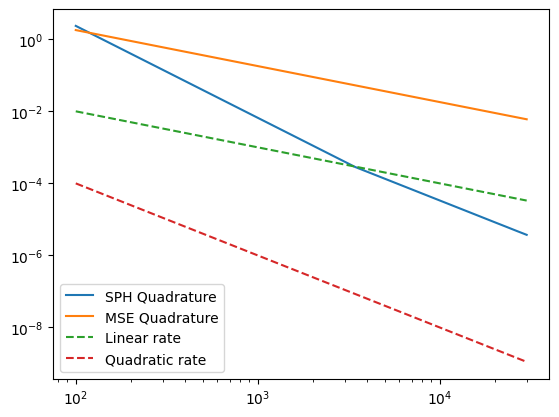

In [28]:
plt.loglog(N_p,E_sph,label = 'SPH Quadrature')
plt.loglog(N_p,E_MSE,label = 'MSE Quadrature')
#plt.loglog(N_p,E_MSE_sph,label = 'SPH MSE Quadrature')
plt.loglog(N_p,1/N_p, linestyle='--',label = 'Linear rate')
plt.loglog(N_p, 1/N_p**2,linestyle='--',label = 'Quadratic rate')
plt.legend()